In [3]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [4]:
from pycbc.waveform import get_td_waveform, taper_timeseries
from scipy.special import expit

import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import rfft, irfft, rfftfreq

In [ ]:
def planck_taper(N, epsilon=0.1):
    """
    Planck-taper window.
    """
    if not (0 < epsilon < 0.5):
        raise ValueError("epsilon must be between 0 and 0.5")

    w = np.ones(N)
    L = int(epsilon * N)

    if L == 0:
        return w

    n = np.arange(1, L)
    x = L/n - L/(L-n)
    w[:L-1] = expit(-x)
    w[0] = 0.0

    x = L/(L-n) - L/n
    w[-(L-1):] = expit(-x)
    w[-1] = 0.0

    return w

In [28]:
hp, _ = get_td_waveform(approximant="teobresums", mass1=30, mass2=30, eccentricity=0.2, lambda1=0, lambda2=0, delta_t=1.0/(4*4096), f_lower=10)
hp = taper_timeseries(hp, tapermethod="TAPER_STARTEND", return_lal=False)
# hp = planck_taper(len(hp), epsilon=0.1) * hp

In [29]:
hp = np.asanyarray(hp)

In [30]:
length = hp.__len__()
pad = int(2**(np.ceil(np.log2(length)) + 2))

In [31]:
hp = np.pad(hp, (0, pad - length))

In [32]:
hp_fd_freq = rfftfreq(len(hp), 1.0/(4*4096))
hp_fd = rfft(hp)

In [33]:
hp_fd_freq.max()

np.float64(8192.0)

In [34]:
hp_fd_amp = np.abs(hp_fd)
hp_fd_phase = np.unwrap(np.angle(hp_fd))

In [35]:
poly_fit = np.polyfit(hp_fd_freq, hp_fd_phase, 1)
linear_phase = np.polyval(poly_fit, hp_fd_freq)
phase_centered = hp_fd_phase - linear_phase

phase_offset = phase_centered[0]
phase_anchored = phase_centered - phase_offset

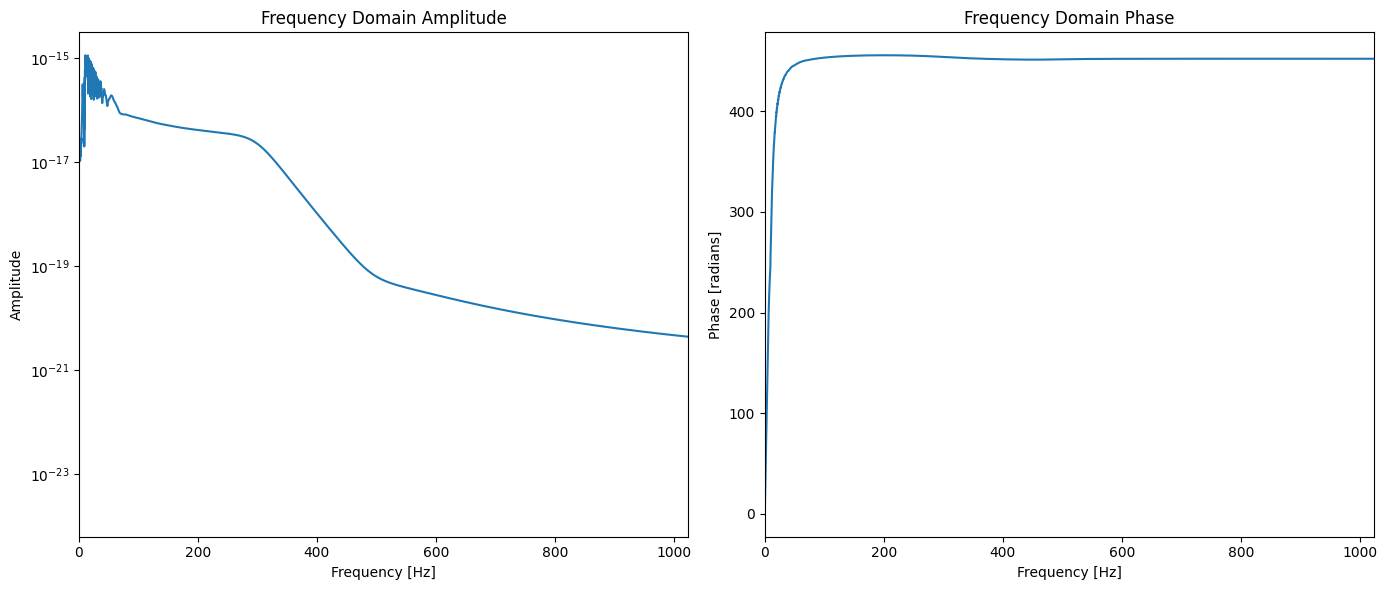

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(hp_fd_freq, hp_fd_amp)
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Frequency Domain Amplitude")
ax[0].set_yscale("log")
ax[0].set_xlim(0, 1024)
# ax[0].set_ylim(0, hp_fd_amp.max()*1.1)

ax[1].plot(hp_fd_freq, phase_anchored)
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Phase [radians]")
ax[1].set_title("Frequency Domain Phase")
ax[1].set_yscale("linear")
ax[1].set_xlim(0, 1024)
# ax[1].set_ylim(-np.pi, np.pi)

plt.tight_layout()
plt.show()